In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [10]:
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

C:\Users\Andy\Anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()


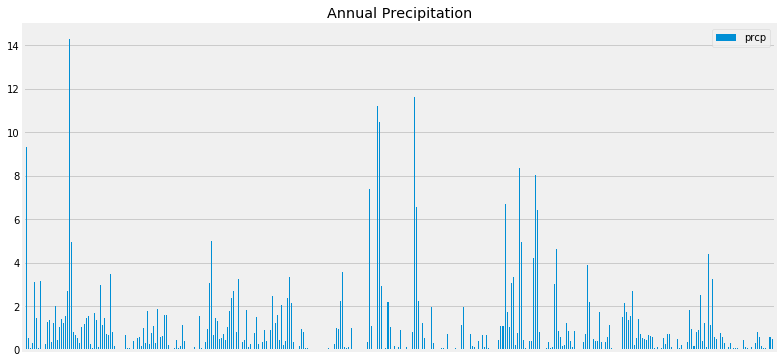

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date = np.ravel(last_date)
last_date
# Perform a query to retrieve the data and precipitation scores
data = session.query(Measurement.date,func.sum(Measurement.prcp)).filter(Measurement.date.between('2016-08-23', last_date)).\
    group_by(Measurement.date).all()
data
# Save the query results as a Pandas DataFrame and set the index to the date column
data_df = pd.DataFrame(data, columns=['date','prcp']).sort_values('date').set_index('date')
data_df
# Sort the dataframe by date

# # # Use Pandas Plotting with Matplotlib to plot the data
graph_data = data_df.plot.bar(ylim = (0,15.0), title = 'Annual Precipitation', figsize = (12,6), xticks = None)
ax1 = plt.axes()
x_axis = ax1.axes.get_xaxis()
x_axis.set_visible(False)
plt.show()

![precipitation](Images/precipitation.png)

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
stats = data_df.describe()
stats

,prcp
count,366.000000
mean,0.978907
std,1.776349
min,0.000000
25%,0.052500
50%,0.405000
75%,1.087500
max,14.280000


![describe](Images/describe.png)

In [14]:
# Design a query to show how many stations are available in this dataset?
no_stations = session.query(Station).count()
no_stations

9

In [15]:
stations = session.query(Station.station).all()
stations = np.ravel(stations)
stations
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_active = []

for sta in stations:
    counter = session.query(Measurement).filter(Measurement.station == sta).count()
    most_active.append(counter)

most_active

station_df = pd.DataFrame({'station':stations, 'activity':most_active})
station_df = station_df.sort_values('activity', ascending = False).reset_index(drop=True)
station_df

,station,activity
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
busy_station = station_df.iloc[0][0]
busy_station

highT = session.query(Measurement.tobs).filter(Measurement.station == busy_station).\
    order_by(Measurement.tobs.desc()).first()
highT

lowT = session.query(Measurement.tobs).filter(Measurement.station == busy_station).\
    order_by(Measurement.tobs).first()
lowT

avgT = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == busy_station).all()
avgT = list(np.ravel(avgT))
avgT

busy_sta_df = pd.DataFrame({'station': busy_station, 'low temp': lowT, 'high temp': highT, 'avg temp': avgT})
busy_sta_df

,station,low temp,high temp,avg temp
0,USC00519281,54.0,85.0,71.663781


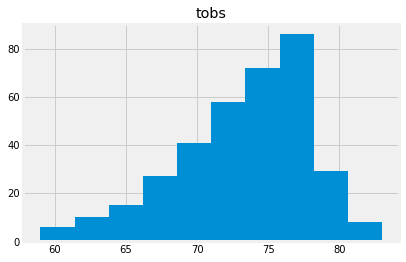

In [17]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tempdata = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == busy_station).\
    filter(Measurement.date.between('2016-08-23', last_date)).all()
tempdata
# Save the query results as a Pandas DataFrame and set the index to the date column
tempdata_df = pd.DataFrame(tempdata).set_index('date')
tempdata_df['tobs'] = tempdata_df['tobs'].dropna()
tempdata_df

temp_hist = tempdata_df.hist()
plt.show()

![precipitation](Images/station-histogram.png)

In [18]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [19]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_temps = calc_temps('2017-06-15', '2017-06-30')
trip_temps = list(np.ravel(trip_temps))
print(trip_temps)
lowT = trip_temps[0]
avgT = trip_temps[1]
highT = trip_temps[2]
tdiff = highT - lowT
trip_df = pd.DataFrame({'low T':[lowT], 'avg T':avgT, 'high T':highT, 'T diff':tdiff})
trip_df

[71.0, 77.01980198019803, 82.0]


,low T,avg T,high T,T diff
0,71.0,77.019802,82.0,11.0


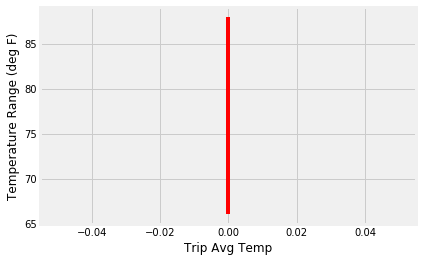

In [22]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.xlabel("Trip Avg Temp")
plt.errorbar(x=0, y=avgT, yerr = tdiff, ecolor = 'r')
plt.ylabel("Temperature Range (deg F)")
plt.show()

In [33]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
rainfall = session.query(Measurement.station, Station.name, func.sum(Measurement.prcp), Station.latitude, Station.longitude, Station.elevation).\
                        filter(Measurement.date.between('2017-06-15', '2017-06-30')).\
                        filter(Measurement.station == Station.station).group_by(Measurement.station).\
                        order_by(Measurement.prcp.desc()).all()
rainfall
rainfall_df = pd.DataFrame(rainfall, columns=['station','station name','total precip','lat','lng','elevation'])
rainfall_df

,station,station name,total precip,lat,lng,elevation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",5.48,21.33310,-157.80250,152.4
1,USC00519281,"WAIHEE 837.5, HI US",1.83,21.45167,-157.84889,32.9
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",0.88,21.52130,-157.83740,7.0
3,USC00513117,"KANEOHE 838.1, HI US",1.19,21.42340,-157.80150,14.6
4,USC00519397,"WAIKIKI 717.2, HI US",0.21,21.27160,-157.81680,3.0
5,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",0.13,21.33556,-157.71139,19.5
6,USC00517948,"PEARL CITY, HI US",0.12,21.39340,-157.97510,11.9


## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
